### Data Privacy And Protection : PII Anonymisation


In this notebook, we will look at building a basic system for question answering, based on private data. Before feeding the LLM with this data, we need to protect it so that it doesn't go to an external API (e.g. OpenAI, Anthropic). 

Then, after receiving the model output, we would like the data to be restored to its original form. Below you can observe an example flow of this QA system:

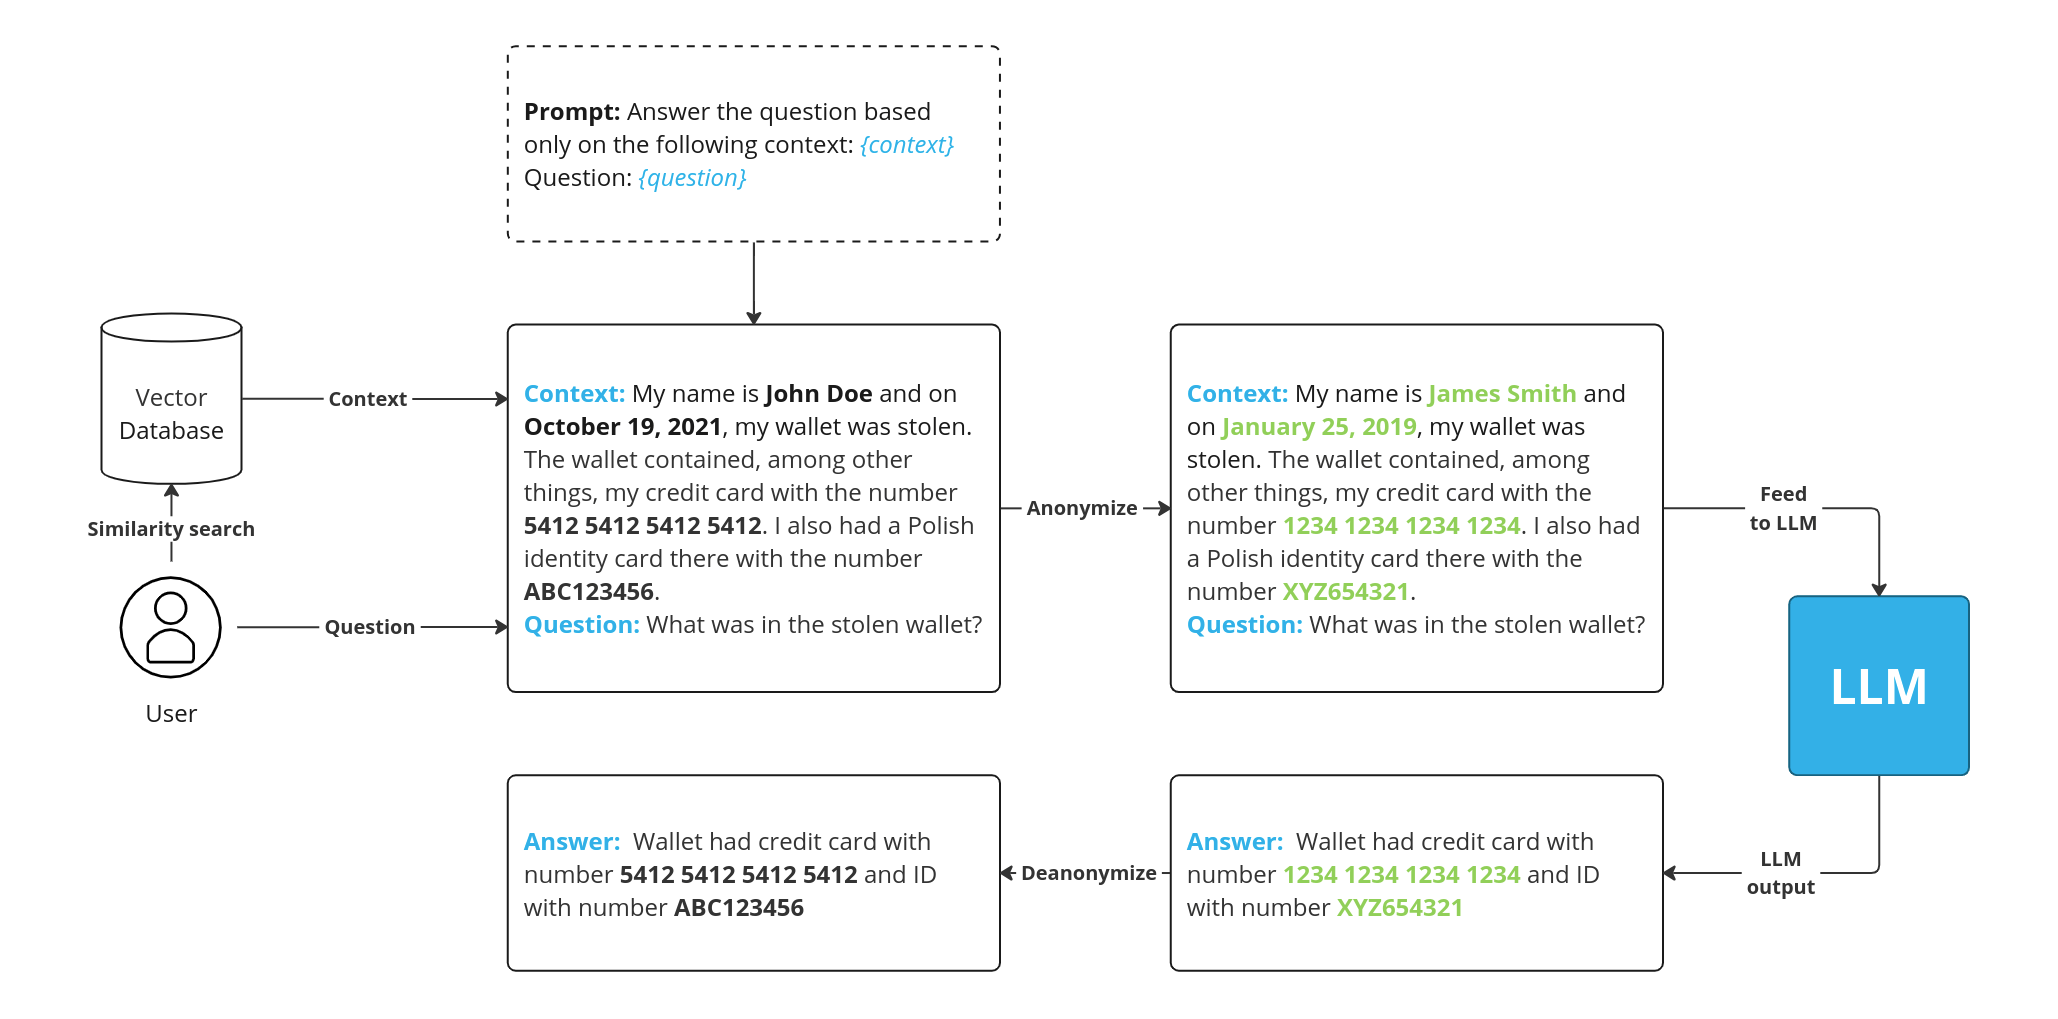

In [1]:
from IPython.display import Image
Image("https://python.langchain.com/img/qa_privacy_protection.png")

### Setting Work Envirement

In [2]:
# Install necessary packages
#%pip install --upgrade --quiet  langchain langchain-experimental langchain-openai presidio-analyzer presidio-anonymizer spacy Faker

# I already installed them in my local env

About The model "en_core_web_lg" :

* en_core_web_lg is a large English language model provided by spaCy.
* It contains word vectors, part-of-speech tagging, named entity recognition, and dependency parsing.
* The "lg" in the name stands for "large," indicating that this model has more features and provides better accuracy compared to the smaller models (e.g., en_core_web_sm).

In [3]:
# Download model
! python -m spacy download en_core_web_lg

     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.3/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.3/587.7 MB ? eta -:--:--
     -------------------------------------- 0.5/587.7 MB 558.9 kB/s eta 0:17:31
     -------------------------------------- 0.8/587.7 MB 762.0 kB/s eta 0:12:51
     -------------------------------------- 1.0/587.7 MB 882.6 kB/s eta 0:11:05
     -------------------------------------- 1.3/587.7 MB 958.5 kB/s eta 0:10:12
     ---------------------------------------- 1.6/587.7 MB 1.0 MB/s eta 0:09:34
     ---------------------------------------- 1.8/587.7 MB 1.1 MB/s eta 0:09:14
     ---------------------------------------- 2.1/587.7 MB 1.1 MB/s eta 0:08:59
  

In [8]:
document_content = """Date: October 19, 2021
 Witness: John Doe
 Subject: Testimony Regarding the Loss of Wallet

 Testimony Content:

 Hello Officer,

 My name is John Doe and on October 19, 2021, my wallet was stolen in the vicinity of Kilmarnock during a bike trip. This wallet contains some very important things to me.

 Firstly, the wallet contains my credit card with number 4111 1111 1111 1111, which is registered under my name and linked to my bank account, PL61109010140000071219812874.

 Additionally, the wallet had a driver's license - DL No: 999000680 issued to my name. It also houses my Social Security Number, 602-76-4532.

 What's more, I had my polish identity card there, with the number ABC123456.

 I would like this data to be secured and protected in all possible ways. I believe It was stolen at 9:30 AM.

 In case any information arises regarding my wallet, please reach out to me on my phone number, 999-888-7777, or through my personal email, johndoe@example.com.

 Please consider this information to be highly confidential and respect my privacy.

 The bank has been informed about the stolen credit card and necessary actions have been taken from their end. They will be reachable at their official email, support@bankname.com.
 My representative there is Victoria Cherry (her business phone: 987-654-3210).

 Thank you for your assistance,

 John Doe"""

In [9]:
# Import the Document class from langchain_core
from langchain_core.documents import Document

# Create a list of documents, where each document is an instance of the Document class
# The page_content parameter holds the actual content of the document
documents = [Document(page_content=document_content)]


In [12]:
# Utility function for coloring the PII (Personally Identifiable Information) markers in a string

import re  # Import the regular expressions module for pattern matching

# Define a function that prints PII markers in red color
def print_colored_pii(string):
    # Use a regular expression to find patterns enclosed in "< >" and color them red
    colored_string = re.sub(
        r"(<[^>]*>)",          # Match any text enclosed in angle brackets "<...>"
        lambda m: "\033[31m" + m.group(1) + "\033[0m",  string      # Color the matched text red using ANSI escape codes
    )
    # Print the string with colored PII markers
    print(colored_string)


Let's proceed and try to anonymize the text with the default settings. 

For now, we don't replace the data with synthetic, we just mark it with markers (e.g. <PERSON>), so we set add_default_faker_operators=False:

In [13]:
# Import the PresidioReversibleAnonymizer class from langchain_experimental for data anonymization
from langchain_experimental.data_anonymizer import PresidioReversibleAnonymizer

# Create an instance of the PresidioReversibleAnonymizer class
# Set add_default_faker_operators to False, meaning custom faker operators can be used instead of default ones
anonymizer = PresidioReversibleAnonymizer(
    add_default_faker_operators=False,
)

# Use the print_colored_pii function to print the anonymized content
# The anonymizer.anonymize method anonymizes the content of document_content
print_colored_pii(anonymizer.anonymize(document_content))


Date: <DATE_TIME>
 Witness: <PERSON>
 Subject: Testimony Regarding the Loss of Wallet

 Testimony Content:

 Hello Officer,

 My name is <PERSON> and on <DATE_TIME>, my wallet was stolen in the vicinity of <LOCATION> during a bike trip. This wallet contains some very important things to me.

 Firstly, the wallet contains my credit card with number <CREDIT_CARD>, which is registered under my name and linked to my bank account, <IBAN_CODE>.

 Additionally, the wallet had a driver's license - DL No: <US_DRIVER_LICENSE> issued to my name. It also houses my Social Security Number, <US_SSN>.

 What's more, I had my polish identity card there, with the number ABC123456.

 I would like this data to be secured and protected in all possible ways. I believe It was stolen at <DATE_TIME_2>.

 In case any information arises regarding my wallet, please reach out to me on my phone number, <PHONE_NUMBER>, or through my personal email, <EMAIL_ADDRESS>.

 Please consider this information to be highly con

Explanation:
* This text contains multiple placeholders for Personally Identifiable Information (PII) like <PERSON>, <DATE_TIME>, <CREDIT_CARD>, <PHONE_NUMBER>, etc.
* These placeholders indicate where sensitive information is located, and should be anonymized to protect privacy.
* The print_colored_pii function and PresidioReversibleAnonymizer can be used to detect, anonymize, and highlight such information in the text.

Let's also look at the mapping between original and anonymized values:



In [14]:
# Import the pprint module for pretty-printing data structures
import pprint

# Pretty-print the deanonymizer_mapping attribute of the anonymizer object
# This mapping contains information that allows reversing the anonymization process
pprint.pprint(anonymizer.deanonymizer_mapping)


{'CREDIT_CARD': {'<CREDIT_CARD>': '4111 1111 1111 1111'},
 'DATE_TIME': {'<DATE_TIME>': 'October 19, 2021', '<DATE_TIME_2>': '9:30 AM'},
 'EMAIL_ADDRESS': {'<EMAIL_ADDRESS>': 'johndoe@example.com',
                   '<EMAIL_ADDRESS_2>': 'support@bankname.com'},
 'IBAN_CODE': {'<IBAN_CODE>': 'PL61109010140000071219812874'},
 'LOCATION': {'<LOCATION>': 'Kilmarnock'},
 'PERSON': {'<PERSON>': 'John Doe', '<PERSON_2>': 'Victoria Cherry'},
 'PHONE_NUMBER': {'<PHONE_NUMBER>': '999-888-7777'},
 'UK_NHS': {'<UK_NHS>': '987-654-3210'},
 'US_DRIVER_LICENSE': {'<US_DRIVER_LICENSE>': '999000680'},
 'US_SSN': {'<US_SSN>': '602-76-4532'}}


In general, the anonymizer works pretty well, but I can observe two things to improve here:

* Datetime redundancy - we have two different entities recognized as DATE_TIME, but they contain different type of information. The first one is a date (October 19, 2021), the second one is a time (9:30 AM). We can improve this by adding a new recognizer to the anonymizer, which will treat time separately from the date.
* Polish ID - polish ID has unique pattern, which is not by default part of anonymizer recognizers. The value ABC123456 is not anonymized.
The solution is simple: we need to add a new recognizers to the anonymizer. 

In [15]:
# Import the Pattern and PatternRecognizer classes from presidio_analyzer
from presidio_analyzer import Pattern, PatternRecognizer

# Define a regex pattern for detecting a Polish identity card number
# The pattern "[A-Z]{3}\d{6}" matches three uppercase letters followed by six digits
polish_id_pattern = Pattern(
    name="polish_id_pattern",  # Name of the pattern
    regex="[A-Z]{3}\d{6}",      # Regular expression to match Polish identity card format
    score=1,                    # Confidence score for the pattern (1 indicates high confidence)
)

# Define a regex pattern for detecting time in "HH:MM AM/PM" format
# The pattern matches a time in either 12-hour format with AM or PM
time_pattern = Pattern(
    name="time_pattern",  # Name of the pattern
    regex="(1[0-2]|0?[1-9]):[0-5][0-9] (AM|PM)",  # Regular expression to match time format
    score=1,  # Confidence score for the pattern (1 indicates high confidence)
)

# Define a recognizer using the pattern for Polish ID
polish_id_recognizer = PatternRecognizer(
    supported_entity="POLISH_ID",  # Name of the entity to recognize
    patterns=[polish_id_pattern]   # List of patterns used by the recognizer
)

# Define a recognizer using the pattern for time
time_recognizer = PatternRecognizer(
    supported_entity="TIME",  # Name of the entity to recognize
    patterns=[time_pattern]   # List of patterns used by the recognizer
)


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Firas\AppData\Local\Temp\ipykernel_14160\1912350876.py:8: SyntaxWarning: invalid escape sequence '\d'
  regex="[A-Z]{3}\d{6}",      # Regular expression to match Polish identity card format


And now, we're adding recognizers to our anonymizer:

In [16]:
# Add the custom recognizer for Polish ID to the anonymizer
anonymizer.add_recognizer(polish_id_recognizer)

# Add the custom recognizer for time to the anonymizer
anonymizer.add_recognizer(time_recognizer)


Note that our anonymization instance remembers previously detected and anonymized values, including those that were not detected correctly (e.g., "9:30 AM" taken as DATE_TIME). So it's worth removing this value, or resetting the entire mapping now that our recognizers have been updated:

In [18]:
# Reset the mapping used for deanonymization in the anonymizer
anonymizer.reset_deanonymizer_mapping()


Let's anonymize the text and see the results:


In [19]:
# Use the anonymizer to anonymize the content of the document
# The anonymize method replaces PII with placeholder values
# The print_colored_pii function is used to print the anonymized content, highlighting PII markers in red
print_colored_pii(anonymizer.anonymize(document_content))


Date: <DATE_TIME>
 Witness: <PERSON>
 Subject: Testimony Regarding the Loss of Wallet

 Testimony Content:

 Hello Officer,

 My name is <PERSON> and on <DATE_TIME>, my wallet was stolen in the vicinity of <LOCATION> during a bike trip. This wallet contains some very important things to me.

 Firstly, the wallet contains my credit card with number <CREDIT_CARD>, which is registered under my name and linked to my bank account, <IBAN_CODE>.

 Additionally, the wallet had a driver's license - DL No: <US_DRIVER_LICENSE> issued to my name. It also houses my Social Security Number, <US_SSN>.

 What's more, I had my polish identity card there, with the number <POLISH_ID>.

 I would like this data to be secured and protected in all possible ways. I believe It was stolen at <TIME>.

 In case any information arises regarding my wallet, please reach out to me on my phone number, <PHONE_NUMBER>, or through my personal email, <EMAIL_ADDRESS>.

 Please consider this information to be highly confiden

In [20]:
# Pretty-print the deanonymizer_mapping attribute of the anonymizer object
# This mapping contains information that maps the anonymized values back to their original values
pprint.pprint(anonymizer.deanonymizer_mapping)


{'CREDIT_CARD': {'<CREDIT_CARD>': '4111 1111 1111 1111'},
 'DATE_TIME': {'<DATE_TIME>': 'October 19, 2021'},
 'EMAIL_ADDRESS': {'<EMAIL_ADDRESS>': 'johndoe@example.com',
                   '<EMAIL_ADDRESS_2>': 'support@bankname.com'},
 'IBAN_CODE': {'<IBAN_CODE>': 'PL61109010140000071219812874'},
 'LOCATION': {'<LOCATION>': 'Kilmarnock'},
 'PERSON': {'<PERSON>': 'John Doe', '<PERSON_2>': 'Victoria Cherry'},
 'PHONE_NUMBER': {'<PHONE_NUMBER>': '999-888-7777'},
 'POLISH_ID': {'<POLISH_ID>': 'ABC123456'},
 'TIME': {'<TIME>': '9:30 AM'},
 'UK_NHS': {'<UK_NHS>': '987-654-3210'},
 'US_DRIVER_LICENSE': {'<US_DRIVER_LICENSE>': '999000680'},
 'US_SSN': {'<US_SSN>': '602-76-4532'}}


As you can see, our new recognizers work as expected. The anonymizer has replaced the time and Polish ID entities with the <TIME> and <POLISH_ID> markers, and the deanonymizer mapping has been updated accordingly.

Now, when all PII values are detected correctly, we can proceed to the next step, which is replacing the original values with synthetic ones. To do this, we need to set add_default_faker_operators=True (or just remove this parameter, because it's set to True by default):

In [21]:
# Create a new instance of the PresidioReversibleAnonymizer with additional options
anonymizer = PresidioReversibleAnonymizer(
    add_default_faker_operators=True,  # Use default faker operators for generating fake data
    faker_seed=42,  # Set a seed for the faker to ensure reproducibility of generated data (useful for testing)
    # In production, it's recommended to remove the faker_seed for better randomness
)

# Add the custom recognizer for Polish ID to the anonymizer
anonymizer.add_recognizer(polish_id_recognizer)

# Add the custom recognizer for time to the anonymizer
anonymizer.add_recognizer(time_recognizer)

# Use the anonymizer to anonymize the document content
# Print the anonymized content, highlighting the PII markers in red
print_colored_pii(anonymizer.anonymize(document_content))


Date: 1986-04-18
 Witness: Brian Cox DVM
 Subject: Testimony Regarding the Loss of Wallet

 Testimony Content:

 Hello Officer,

 My name is Brian Cox DVM and on 1986-04-18, my wallet was stolen in the vicinity of New Rita during a bike trip. This wallet contains some very important things to me.

 Firstly, the wallet contains my credit card with number 6584801845146275, which is registered under my name and linked to my bank account, GB78GSWK37672423884969.

 Additionally, the wallet had a driver's license - DL No: 781802744 issued to my name. It also houses my Social Security Number, 687-35-1170.

 What's more, I had my polish identity card there, with the number <POLISH_ID>.

 I would like this data to be secured and protected in all possible ways. I believe It was stolen at <TIME>.

 In case any information arises regarding my wallet, please reach out to me on my phone number, 7344131647, or through my personal email, jamesmichael@example.com.

 Please consider this information to 

As you can see, almost all values have been replaced with synthetic ones. The only exception is the Polish ID number and time, which are not supported by the default faker operators. We can add new operators to the anonymizer, which will generate random data. 

In [22]:
# Import the Faker library for generating fake data
from faker import Faker

# Create an instance of the Faker class
fake = Faker()

# Define a function to generate a fake Polish ID number
def fake_polish_id(_=None):
    # Use Faker's bothify function to generate a string with three uppercase letters and six digits
    # Convert the generated string to uppercase to match the format of a Polish ID
    return fake.bothify(text="???######").upper()

# Call the fake_polish_id function to generate and return a fake Polish ID
fake_polish_id()


'HHJ854212'

In [23]:
# Define a function to generate a fake time value
def fake_time(_=None):
    # Generate a fake time in the "HH:MM AM/PM" format using the Faker library
    return fake.time(pattern="%I:%M %p")

# Call the function to generate a fake time
fake_time()


'05:34 AM'

Let's add newly created operators to the anonymizer:


In [24]:
# Import the OperatorConfig class from presidio_anonymizer.entities
from presidio_anonymizer.entities import OperatorConfig

# Define a dictionary of new operators for anonymizing custom entities
new_operators = {
    "POLISH_ID": OperatorConfig("custom", {"lambda": fake_polish_id}),  # Use the custom fake_polish_id function for POLISH_ID
    "TIME": OperatorConfig("custom", {"lambda": fake_time}),  # Use the custom fake_time function for TIME
}

# Add the new operators to the anonymizer
anonymizer.add_operators(new_operators)


And anonymize everything once again:



In [25]:
# Reset the mapping used for deanonymization in the anonymizer
anonymizer.reset_deanonymizer_mapping()

# Use the anonymizer to anonymize the content of the document again
# Print the anonymized content, highlighting the PII markers in red
print_colored_pii(anonymizer.anonymize(document_content))


Date: 1974-12-26
 Witness: Jimmy Murillo
 Subject: Testimony Regarding the Loss of Wallet

 Testimony Content:

 Hello Officer,

 My name is Jimmy Murillo and on 1974-12-26, my wallet was stolen in the vicinity of South Dianeshire during a bike trip. This wallet contains some very important things to me.

 Firstly, the wallet contains my credit card with number 213108121913614, which is registered under my name and linked to my bank account, GB17DBUR01326773602606.

 Additionally, the wallet had a driver's license - DL No: 532311310 issued to my name. It also houses my Social Security Number, 690-84-1613.

 What's more, I had my polish identity card there, with the number POJ975529.

 I would like this data to be secured and protected in all possible ways. I believe It was stolen at 06:53 PM.

 In case any information arises regarding my wallet, please reach out to me on my phone number, 876.931.1656, or through my personal email, briannasmith@example.net.

 Please consider this inform

In [26]:
pprint.pprint(anonymizer.deanonymizer_mapping)


{'CREDIT_CARD': {'213108121913614': '4111 1111 1111 1111'},
 'DATE_TIME': {'1974-12-26': 'October 19, 2021'},
 'EMAIL_ADDRESS': {'briannasmith@example.net': 'johndoe@example.com',
                   'samuel87@example.org': 'support@bankname.com'},
 'IBAN_CODE': {'GB17DBUR01326773602606': 'PL61109010140000071219812874'},
 'LOCATION': {'South Dianeshire': 'Kilmarnock'},
 'PERSON': {'Jimmy Murillo': 'John Doe', 'Joshua Blair': 'Victoria Cherry'},
 'PHONE_NUMBER': {'876.931.1656': '999-888-7777'},
 'POLISH_ID': {'POJ975529': 'ABC123456'},
 'TIME': {'06:53 PM': '9:30 AM'},
 'UK_NHS': {'3361388464': '987-654-3210'},
 'US_DRIVER_LICENSE': {'532311310': '999000680'},
 'US_SSN': {'690-84-1613': '602-76-4532'}}


Now all values are replaced with synthetic ones. Note that the deanonymizer mapping has been updated accordingly.

## Question-answering system with PII anonymization

Now, let's wrap it up together and create full question-answering system, based on PresidioReversibleAnonymizer and LangChain Expression Language (LCEL).



In [27]:
# 1. Initialize the PresidioReversibleAnonymizer
anonymizer = PresidioReversibleAnonymizer(
    # Set a seed for the faker to ensure consistent fake data generation during testing
    # It's advisable to remove the faker_seed parameter in production for better randomness
    faker_seed=42,
)

# Add custom recognizers to detect Polish ID and time entities in the text
anonymizer.add_recognizer(polish_id_recognizer)
anonymizer.add_recognizer(time_recognizer)

# Add the new operators for generating fake data for the recognized entities
anonymizer.add_operators(new_operators)


In [38]:
import openai
# Set up your OpenAI API key
api_key = "paste your api key here "
openai.api_key = api_key

In [ ]:
# Import necessary libraries for vector storage and embeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 2. Load the data: In our case, the data is already loaded in the `documents` variable

# 3. Anonymize the data before indexing
# Iterate through each document and anonymize its content
for doc in documents:
    doc.page_content = anonymizer.anonymize(doc.page_content)

# 4. Split the documents into chunks
# Create an instance of RecursiveCharacterTextSplitter to split documents into manageable chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Split the documents into chunks based on the defined parameters
chunks = text_splitter.split_documents(documents)

# 5. Index the chunks using OpenAI embeddings after the data has been anonymized
# Create an instance of OpenAIEmbeddings for generating embeddings from the document chunks
embeddings = OpenAIEmbeddings(api_key=api_key)

# Use FAISS to index the document chunks along with their embeddings
docsearch = FAISS.from_documents(chunks, embeddings)

# Convert the FAISS index into a retriever for efficient querying
retriever = docsearch.as_retriever()


In [ ]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_openai import ChatOpenAI

# 6. Create the anonymizer chain
# Define the template for the prompt to ask questions based on a provided context
template = """Answer the question based only on the following context:
{context}

Question: {anonymized_question}
"""
# Create a ChatPromptTemplate from the defined template
prompt = ChatPromptTemplate.from_template(template)

# Initialize the ChatOpenAI model with a specified temperature
# A lower temperature makes the output more focused and deterministic
model = ChatOpenAI(temperature=0.3)

# Prepare the inputs for the runnable chain
_inputs = RunnableParallel(
    question=RunnablePassthrough(),  # The original question will be passed through as is
    # Anonymize the question using the anonymizer
    anonymized_question=RunnableLambda(anonymizer.anonymize),
)

# Build the anonymizer chain
anonymizer_chain = (
    _inputs
    | {
        # Retrieve context based on the anonymized question from the retriever
        "context": itemgetter("anonymized_question") | retriever,
        # Pass the anonymized question along the chain
        "anonymized_question": itemgetter("anonymized_question"),
    }
    | prompt  # Create the prompt using the context and anonymized question
    | model   # Pass the prompt to the ChatOpenAI model for processing
    | StrOutputParser()  # Parse the output into a string format
)


In [ ]:
anonymizer_chain.invoke(
    "Where did the theft of the wallet occur, at what time, and who was it stolen from?"
)

'The theft of the wallet occurred in the vicinity of New Rita during a bike trip. It was stolen from Brian Cox DVM. The time of the theft was 02:22 AM.'



In [ ]:
# 7. Add deanonymization step to the chain
chain_with_deanonymization = anonymizer_chain | RunnableLambda(anonymizer.deanonymize)

print(
    chain_with_deanonymization.invoke(
        "Where did the theft of the wallet occur, at what time, and who was it stolen from?"
    )
)

The theft of the wallet occurred in the vicinity of Kilmarnock during a bike trip. It was stolen from John Doe. The time of the theft was 9:30 AM.

In [ ]:
print(
    chain_with_deanonymization.invoke("What was the content of the wallet in detail?")
)

The content of the wallet included a credit card with the number 4111 1111 1111 1111, registered under the name of John Doe and linked to the bank account PL61109010140000071219812874. It also contained a driver's license with the number 999000680 issued to John Doe, as well as his Social Security Number 602-76-4532. Additionally, the wallet had a Polish identity card with the number ABC123456.




In [ ]:
print(chain_with_deanonymization.invoke("Whose phone number is it: 999-888-7777?"))

The phone number 999-888-7777 belongs to John Doe.

